In [6]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import sys 
import pandas as pd
import os
import optuna
import matplotlib.pylab as plt
%matplotlib inline
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torchcontrib.optim import SWA
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser
sys.path.append('../data/')
sys.path.append('../data/synthetic')
sys.path.append('../ief_core/')
sys.path.append('../ief_core/models/')
from synthetic_data import load_synthetic_data_trt, load_synthetic_data_noisy
from models.ssm.ssm import SSM, SSMAtt
from models.ssm.ssm_baseline import SSMBaseline
from models.rnn import GRU
from models.base import DataModule
from models.utils import *
print(torch.__version__)

1.7.1


In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

def get_scolor():
    scolor = {}
    scolor[0] = 'k'
    scolor[1] = 'b'
    scolor[2] = 'g'
    scolor[3] = 'r'
    return scolor

## Synthetic Data

In [3]:
nsamples        = {'train':100, 'valid':1000, 'test':1000}
folds           = [0,1,2,3,4]
alpha_1_complex = False; per_missing = 0.; add_feat = 0; num_trt = 1
ddata = load_synthetic_data_trt(fold_span = folds, \
                                nsamples = nsamples, \
                                distractor_dims_b=4, \
                                sigma_ys=0.7, \
                                include_line=True, \
                                alpha_1_complex=alpha_1_complex, \
                                per_missing=per_missing, \
                                add_feats=add_feat, \
                                num_trt=num_trt, \
                                sub=True)

In [4]:
def setup_torch_dataset(ddata, fold, tvt, device=None, oversample=True, att_mask=False, batch_size=600):
    if device is not None: 
        B  = torch.from_numpy(ddata[fold][tvt]['b'].astype('float32')).to(device)
        X  = torch.from_numpy(ddata[fold][tvt]['x'].astype('float32')).to(device)
        A  = torch.from_numpy(ddata[fold][tvt]['a'].astype('float32')).to(device)
        M  = torch.from_numpy(ddata[fold][tvt]['m'].astype('float32')).to(device)
    else: 
        B  = torch.from_numpy(ddata[fold][tvt]['b'].astype('float32'))
        X  = torch.from_numpy(ddata[fold][tvt]['x'].astype('float32'))
        A  = torch.from_numpy(ddata[fold][tvt]['a'].astype('float32'))
        M  = torch.from_numpy(ddata[fold][tvt]['m'].astype('float32'))

    y_vals   = ddata[fold][tvt]['ys_seq'][:,0].astype('float32')
    idx_sort = np.argsort(y_vals)

    if 'digitized_y' in ddata[fold][tvt]:
        print ('using digitized y')
        Y  = torch.from_numpy(ddata[fold][tvt]['digitized_y'].astype('float32'))
    else:
        Y  = torch.from_numpy(ddata[fold][tvt]['ys_seq'][:,[0]]).squeeze()

    if device is not None: 
        Y = Y.to(device)
        CE = torch.from_numpy(ddata[fold][tvt]['ce'].astype('float32')).to(device)
    else: 
        CE = torch.from_numpy(ddata[fold][tvt]['ce'].astype('float32'))

    if att_mask: 
        attn_shape  = (A.shape[0],A.shape[1],A.shape[1])
        Am   = get_attn_mask(attn_shape, ddata[fold][tvt]['a'].astype('float32'), device)
        data = TensorDataset(B[idx_sort], X[idx_sort], A[idx_sort], M[idx_sort], Y[idx_sort], CE[idx_sort], Am[idx_sort])
    else: 
        data = TensorDataset(B[idx_sort], X[idx_sort], A[idx_sort], M[idx_sort], Y[idx_sort], CE[idx_sort])
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    return data, data_loader

In [11]:
sname = {}; models = {}
# Example plots for one model; you should also train an SSM Linear and SSM PK-PD w/o local clock by setting clock_ablation to True in hyperparams
sname['syn_ssm_att'] = '../ief_core/tests/checkpoints/ssm_syn_att1epoch=14958-val_loss=39.48.ckpt'
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device  = torch.device('cpu')
    
for model_n in sname.keys(): 
    checkpoint = torch.load(sname[model_n], map_location=lambda storage, loc: storage)
    hparams    = checkpoint['hyper_parameters']
    hparams['inf_noise'] = 0.
    hparams['zmatrix'] = 'identity'
    hparams['clock_ablation'] = False
    del hparams['trial']
    trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
    model = SSM(trial, **hparams)
    dm = DataModule(hparams, model)
    dm.setup(stage='fit')
    model.load_state_dict(checkpoint['state_dict'])
    models[model_n] = model
    models[model_n].to(device)

training on 1000 samples
using relu in inf. network


In [12]:
folds = [0,1,2,3,4]
for model_ in models: 
    model = models[model_]
    fold_nelbos = []
    for fold in folds: 
        if 'alaa' in model_n:
            data, data_loader = setup_torch_dataset(ddata, fold, 'test', device, att_mask=True)
        else: 
            data, data_loader = setup_torch_dataset(ddata, fold, 'test', device, att_mask=False)

        batch_nelbos = []
        model.eval()
        for i_batch, data_batch_loader in enumerate(data_loader):
            (nelbo, nll, kl, _), _ = model.forward(*data_batch_loader, anneal = 1.)
            nelbo, nll, kl         = nelbo.item(), nll.item(), kl.item()
            batch_nelbos.append(nelbo)
        fold_nelbos.append(np.mean(batch_nelbos))

    print('stats for %s'%model_)
    print('mean NELBO:', np.mean(fold_nelbos))
    print('std NELBO:', np.std(fold_nelbos))

stats for syn_ssm_att
mean NELBO: 39.84641380310059
std NELBO: 0.11548260257008276


## Plotting Results

In [13]:
fold = 1
data, data_loader = setup_torch_dataset(ddata, fold, 'valid', device)
subtype  = ddata[fold]['valid']['subtype']
y_vals   = ddata[fold]['valid']['ys_seq'][:,0].astype('float32').ravel()
idx_sort = np.argsort(y_vals)
sorted_subtype = subtype[idx_sort]
sorted_ys = y_vals[idx_sort]
sorted_xs = ddata[fold]['valid']['x'][idx_sort]
sorted_as = ddata[fold]['valid']['a'][idx_sort]

In [14]:
(B, X, A, M, Y, CE) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
# T_forward  = 10; T_condition = 5
T_forward = 17; T_condition = 2
# B, X, A, M, Y, CE = B[lens>T_forward+T_condition], X[lens>T_forward+T_condition], A[lens>T_forward+T_condition], M[lens>T_forward+T_condition], Y[lens>T_forward+T_condition], CE[lens>T_forward+T_condition]

samples = {}
for name, model in models.items():
    _, _, _, _, _, tforward, _, _ = model.inspect(T_forward, T_condition, B, X, A, M, Y, CE)
    tforw_n = tforward.cpu().detach().numpy()
    samples[name] = tforw_n

> /afs/csail.mit.edu/u/z/zeshanmh/research/ief/ief_core/models/ssm/ssm.py(291)inspect()
    289         m_t, _, lens           = get_masks(M)
    290         import pdb; pdb.set_trace()
--> 291         idx_select = lens>1
    292         B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
    293         m_t, m_g_t, lens   = get_masks(M[:,1:,:])



ipdb>  c


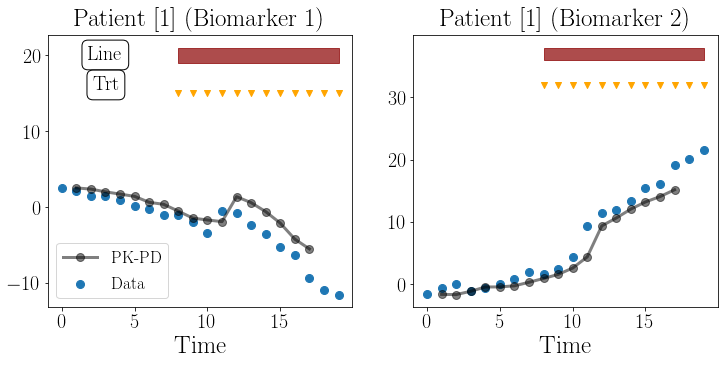

In [15]:
plt.rc('font', family='serif')
fig, axlist = plt.subplots(1,2,figsize=(12,5))
scolor=get_scolor()
fig.subplots_adjust(hspace = 0.4)

model_name  = 'PK-PD'
model_name2  = 'Linear'
model_name3  = 'PK-PD w/o lc'
tvt = 'valid'
pidx = 0
k2alph = {}
k2alph[0] = '(a)'
k2alph[1] = '(b)'
k2alph[2] = '(c)'
k2alph[3] = '(d)'
pt = 1
ks = [1]
axs = axlist.ravel()

for k, ax in enumerate([axs[0]]):    
    idx   = np.where(sorted_subtype==ks[k])[0]
    pred  = samples['syn_ssm_att'][idx[pt]]
    #### other models #####
    
#     pred  = samples['syn_ssm_att_notexp'][idx[pt]]
#     pred2 = samples['syn_ssm_lin'][idx[pt]]
#     pred3 = samples['syn_ssm_att_nolc'][idx[pt]]
    
    data   = sorted_xs[idx[pt],:,:]
    trt_idx= np.where(sorted_as[idx[pt],:,1] == 1.)[0][0]
    xvals  = np.arange(data.shape[0])
    
    tlist_x = []; tlist_y = []
    treat_i = sorted_as[idx[pt],:,1]
    ymax = ax.get_ylim()[1]+0.05
    for t in range(treat_i.shape[0]):
        if treat_i[t] == 1:
            tlist_x.append(t)
            tlist_y.append(15)
    line1 = ax.scatter(tlist_x, tlist_y, marker='v', color='orange')
    line2 = ax.fill_between(tlist_x, np.array(tlist_y)+4, np.array(tlist_y)+6, color='darkred', alpha=0.7)
    
    ax.annotate('Line', xy=(40, 247), xycoords='axes points',
            size=20, bbox=dict(boxstyle='round', fc='w'))
    ax.annotate('Trt', xy=(45, 217), xycoords='axes points',
            size=20, bbox=dict(boxstyle='round', fc='w'))

    ax.scatter(xvals, data[:,0], s = 64, label = 'Data')
    ax.plot(xvals[1:18], pred[:,0],'o-', color='k', label = '%s'%(model_name), linewidth=3., alpha=0.5, markersize=8)
    ### other models 
#     ax.plot(xvals[1:18], pred2[:,0],'x-', color='r', label = '%s'%(model_name2), linewidth=3., alpha=0.5, markersize=8)
#     ax.plot(xvals[1:18], pred3[:,0],'^-', color='darkgrey', label = '%s'%(model_name3), linewidth=3., markersize=8)
    tag = 'S[%d]'%(ks[k])
    ax.set_title('Patient [%d] (Biomarker 1)'%(ks[k]), fontsize=25, pad=10)
    ax.set_xlabel('Time', fontsize=25)
    ax.tick_params(labelsize=20)
    if k == 0: 
        ax.legend(fontsize=17, loc=3)

for k, ax in enumerate([axs[1]]): 
    idx   = np.where(sorted_subtype==ks[k])[0]
    pred  = samples['syn_ssm_att'][idx[pt]]
    ### other models 
#     pred  = samples['syn_ssm_att_notexp'][idx[pt]]
#     pred2 = samples['syn_ssm_lin'][idx[pt]]
#     pred3 = samples['syn_ssm_att_nolc'][idx[pt]]

    data  = sorted_xs[idx[pt],:,:]
    xvals = np.arange(data.shape[0])
    trt_idx= np.where(sorted_as[idx[pt],:,1] == 1.)[0][0]
    
    tlist_x = []; tlist_y = []
    treat_i = sorted_as[idx[pt],:,1]
    for t in range(treat_i.shape[0]):
        if treat_i[t] == 1:
            tlist_x.append(t)
            tlist_y.append(32)
    ax.scatter(tlist_x, tlist_y, marker='v', color='orange')
    ax.fill_between(tlist_x, np.array(tlist_y)+4, np.array(tlist_y)+6, color='darkred', alpha=0.7)
    
    bidx = 2
    ax.scatter(xvals, data[:,1], label = 'Data', s=64)
    ax.plot(xvals[1:18], pred[:,1],'o-', color='k', label = '%s'%(model_name), linewidth=3., alpha=0.5, markersize=8)
#     ax.plot(xvals[1:18], pred2[:,1],'x-', color='r', label = '%s'%(model_name2), linewidth=3., alpha=0.5, markersize=8)
#     ax.plot(xvals[1:18], pred3[:,1],'^-', color='darkgrey', label = '%s'%(model_name3), linewidth=3., markersize=8)
    tag = 'S[%d]'%(ks[k])
    ax.set_title('Patient [%d] (Biomarker %d)'%(ks[k],bidx), fontsize=25, pad=10)
    ax.set_xlabel('Time', fontsize=25)
    ax.tick_params(labelsize=20)
    
plt.savefig('./plots/ssm_syn_joint24_bigfonts_nolc_linetrt.pdf', bbox_inches='tight')